# Исследование метода Рунге-Кутты

Реализация метода Рунге-Кутты (см. https://github.com/matveevk/Differential-Equations-Solver).

In [36]:
# lines to import library
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# other imports
from dif_solver import DifSolver
import matplotlib.pyplot as plt
import math
import numpy as np

## Постановка задачи

В модуле `dif_solver` реализован класс `DifSolver`, решающий задачу Коши методом Рунге-Кутты.

Пусть имеется задача Коши: дано обыкновенное дифференциальное уравнение
$$y'(x) = f(x, y),$$
вместе с начальным условием $$y(x_0) = y_0.$$

Тогда приближение исходной функции $y(x)$ можно вычислить следующим методом (**метод Рунге Кутты порядка 4**).

При заданном (малом) шаге $h > 0$ и взятой последовательности $x_n = x_0 + h\cdot n$, оценить соответствующие значения $y_n$ предлагается по следующей формуле:
$$y_n = y_{n-1} + h\cdot\dfrac{k_1 + 2k_2 + 2k_3 + k_4}{6},$$
где 

$k_1 = f(x_{n-1}, y_{n-1})$,

$k_2 = f(x_{n-1} + \frac{h}2, y_{n-1} + h\frac{k_1}2)$,

$k_3 = f(x_{n-1} + \frac{h}2, y_{n-1} + h\frac{k_2}2)$,

$k_4 = f(x_{n-1} + h, y_{n-1} + hk_3)$.

По сути каждое следующее значение $y$ в точке $x$ вычисляется на основе «предыдущего» уже оценённого значения в точке $x-h$ с помощью прибавления взвешенного изменения $y$ (на основе заданной производной $f$). Ошибка в МРК четвёртого порядка — $O(h^4)$.

Конкретные параметры взвешивания (то есть способы задания $k_i$ вместе с их весами в итоговом выражении) являются параметрами метода, в класс `DifSolver` их можно передавать как параметры $a$, $b$ и $c$.


## Примеры работы модуля для МРК четвёртого порядка

Рассмотрим работу классического Метода Рунге-Кутты на первом примере:

$$y' = x, y(0) = 2,$$ (то есть $y = \frac{x^2}2 + 2$).

In [64]:
equation = "dy/dt = t"
condition = "y(0)=2"
true_func = lambda x: x**2 / 2 + 2

# equation = "dy/dt = cos(t)"
# condition = "y(0)=2"
# true_func = lambda x: math.sin(x) + 2

# equation = "dy/dt = cos(t)*t"
# condition = "y(0)=3"
# true_func = lambda x: x*math.sin(x) + math.cos(x) + 2

# equation = "dy/dt = e^t"
# condition = "y(0)=3"
# true_func = lambda x: math.exp(x) + 2

# not too good res
equation = "dy/dt = y*ln(t)"
condition = "y(1)=1"
true_func = lambda x: (math.e ** -x) * (x ** x) * math.e

# equation = "dy/dx = x*y"
# condition = "y(0)=1"
# true_func = lambda x: math.exp(x**2 / 2)

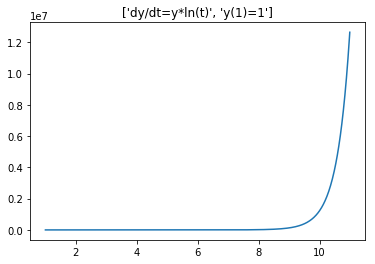

In [65]:
ds = DifSolver(equation=equation, condition=condition)
xs, ys = ds.solve(visualize=True, breadth=10)

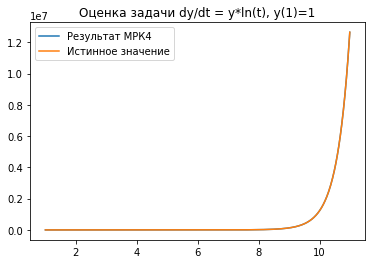

In [66]:
ys_true = list(map(true_func, xs))
plt.plot(xs, ys, label='Результат МРК4')
plt.plot(xs, ys_true, label='Истинное значение')
# plt.plot(xs, abs(ys_true - ys))
plt.legend()
plt.title('Оценка задачи ' + equation+ ', ' + condition)
plt.show()

In [67]:
print('Среднее отклонение МРК от истины:', 
     sum(abs(ys - ys_true)) / len(xs))
print('Последнее отклонение МРК от истины:', abs(ys[-1] - ys_true[-1]))
print('Среднее относительное отклонение МРК от истины:', 
     sum(abs(ys - ys_true)) / len(xs) / np.average(ys_true))
print('Последнее среднее отклонение МРК от истины:', abs(ys[-1] - ys_true[-1]) / abs(ys_true[-1]))

Среднее отклонение МРК от истины: 0.010028997682102485
Последнее отклонение МРК от истины: 0.2656284309923649
Среднее относительное отклонение МРК от истины: 1.846462585656501e-08
Последнее среднее отклонение МРК от истины: 2.1004473090483774e-08


Как видно, МРК четвёртого порядка хорошо себя показывает.

## Обобщённый метод Рунге-Кутты

Параметры пересчёта $k_i$, а также их веса, передаются как параметры: нижнетреугольная матрица a, а также два массива b, c. Размеры --- порядок метода. Устойчивость достигается при $\sum b_i = 1$, где $b_i$ --- коэффициенты при $k_i$.

Метод Рунге-Кутты четвёртого порядка --- частный случай для определённых значений $a$, $b$, $c$.

В класс `DifSolver` передаются как параметры `a`, `b`, `c`, соответственно, в функцию `solve()` (см. описание функции в коде).